# Mathematical Epidemiology with R

This notebook explores **classical infectious disease models** widely used in epidemiology:  

- Compartmental models (SIR, SEIR)  
- Deterministic ODEs and stochastic simulations  
- Reproduction number (R₀)  
- Vaccination and intervention impact  

We will use the `deSolve` package to simulate **epidemic dynamics**.

In [2]:
# Install dependencies
install.packages("deSolve")

# Load library
library(deSolve)

# Example population
N <- 1e5   # total population
I0 <- 1    # initial infected
R0 <- 0    # initial recovered
S0 <- N - I0 - R0  # initial susceptible

# Time span for simulation
times <- seq(0, 160, by=1)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Section 2 — The Basic SIR Model

The **SIR model** is the simplest deterministic infectious disease model:

- **S(t)** = Susceptible population
- **I(t)** = Infected (infectious) population
- **R(t)** = Recovered (removed) population

The dynamics are defined by the system of ODEs:

\[
\frac{dS}{dt} = -\beta \frac{S I}{N}
\]
\[
\frac{dI}{dt} = \beta \frac{S I}{N} - \gamma I
\]
\[
\frac{dR}{dt} = \gamma I
\]

where:

- β = infection rate  
- γ = recovery rate  
- \( R_0 = \beta / \gamma \) is the **basic reproduction number**.

Basic reproduction number (R0): 3 


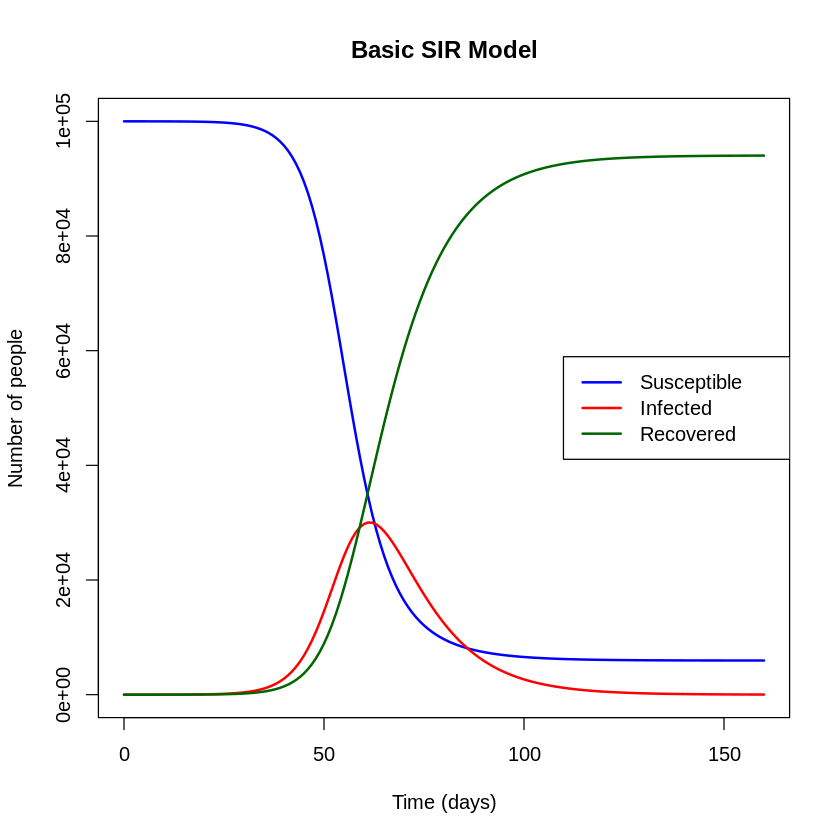

In [3]:
library(deSolve)

# Parameters
beta <- 0.3      # infection rate
gamma <- 0.1     # recovery rate

# Initial state
init <- c(S = S0, I = I0, R = R0)

# SIR equations
sir_model <- function(time, state, parameters) {
  with(as.list(c(state, parameters)), {
    dS <- -beta * S * I / N
    dI <- beta * S * I / N - gamma * I
    dR <- gamma * I
    return(list(c(dS, dI, dR)))
  })
}

# Run simulation
params <- c(beta = beta, gamma = gamma)
out <- ode(y = init, times = times, func = sir_model, parms = params)
out <- as.data.frame(out)

# Plot
matplot(out$time, out[,2:4], type="l", lwd=2, lty=1,
        col=c("blue","red","darkgreen"),
        xlab="Time (days)", ylab="Number of people",
        main="Basic SIR Model")
legend("right", legend=c("Susceptible","Infected","Recovered"),
       col=c("blue","red","darkgreen"), lty=1, lwd=2)

# Basic reproduction number
R0_value <- beta / gamma
cat("Basic reproduction number (R0):", R0_value, "\n")

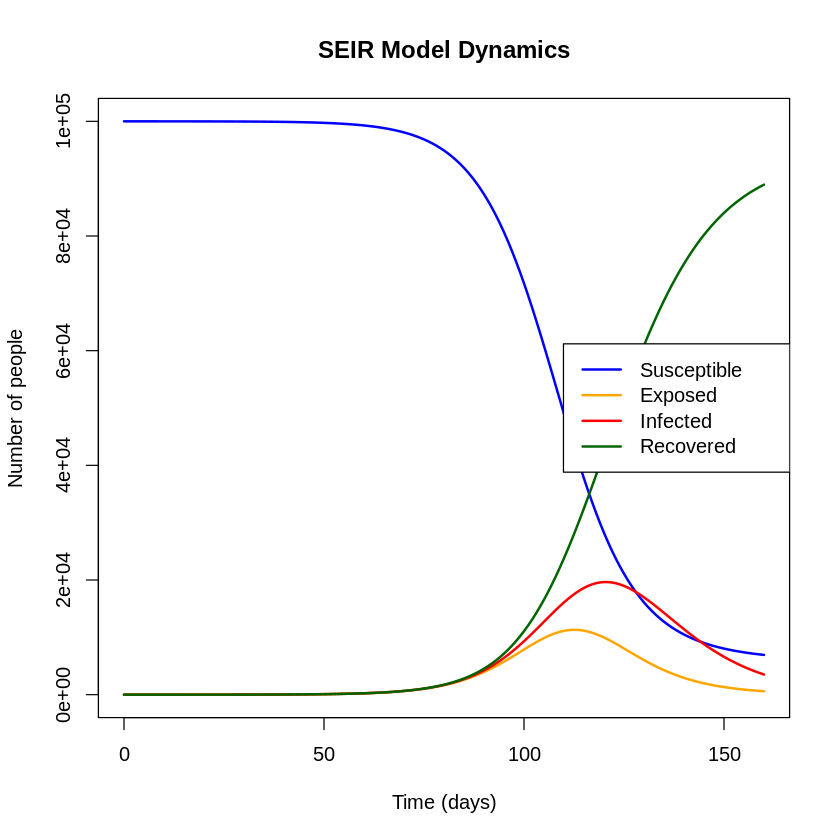

In [5]:
library(deSolve)

# Parameters
beta <- 0.3     # infection rate
gamma <- 0.1    # recovery rate
sigma <- 0.2    # incubation rate (1/5 days)

# Initial conditions
E0 <- 0    # initially no exposed
init_seir <- c(S = S0, E = E0, I = I0, R = R0)

# SEIR model equations
seir_model <- function(time, state, parameters) {
  with(as.list(c(state, parameters)), {
    dS <- -beta * S * I / N
    dE <- beta * S * I / N - sigma * E
    dI <- sigma * E - gamma * I
    dR <- gamma * I
    return(list(c(dS, dE, dI, dR)))
  })
}

# Run simulation
params_seir <- c(beta = beta, gamma = gamma, sigma = sigma)
out_seir <- ode(y = init_seir, times = times, func = seir_model, parms = params_seir)
out_seir <- as.data.frame(out_seir)

# Plot SEIR dynamics
matplot(out_seir$time, out_seir[,2:5], type="l", lwd=2, lty=1,
        col=c("blue","orange","red","darkgreen"),
        xlab="Time (days)", ylab="Number of people",
        main="SEIR Model Dynamics")
legend("right", legend=c("Susceptible","Exposed","Infected","Recovered"),
       col=c("blue","orange","red","darkgreen"), lty=1, lwd=2)

## Section 4 — Extensions to SEIR: Vital Dynamics & Vaccination

Real populations are not closed systems:
- People are born and die (vital dynamics).
- Vaccination reduces the susceptible pool.

We extend the SEIR model with:

- **μ**: per-capita birth & natural death rate  
- **ν**: vaccination rate (moving Susceptible → Recovered)  

ODEs:

\[
\frac{dS}{dt} = \mu N - \beta \frac{S I}{N} - \mu S - \nu S
\]
\[
\frac{dE}{dt} = \beta \frac{S I}{N} - \sigma E - \mu E
\]
\[
\frac{dI}{dt} = \sigma E - \gamma I - \mu I
\]
\[
\frac{dR}{dt} = \gamma I + \nu S - \mu R
\]

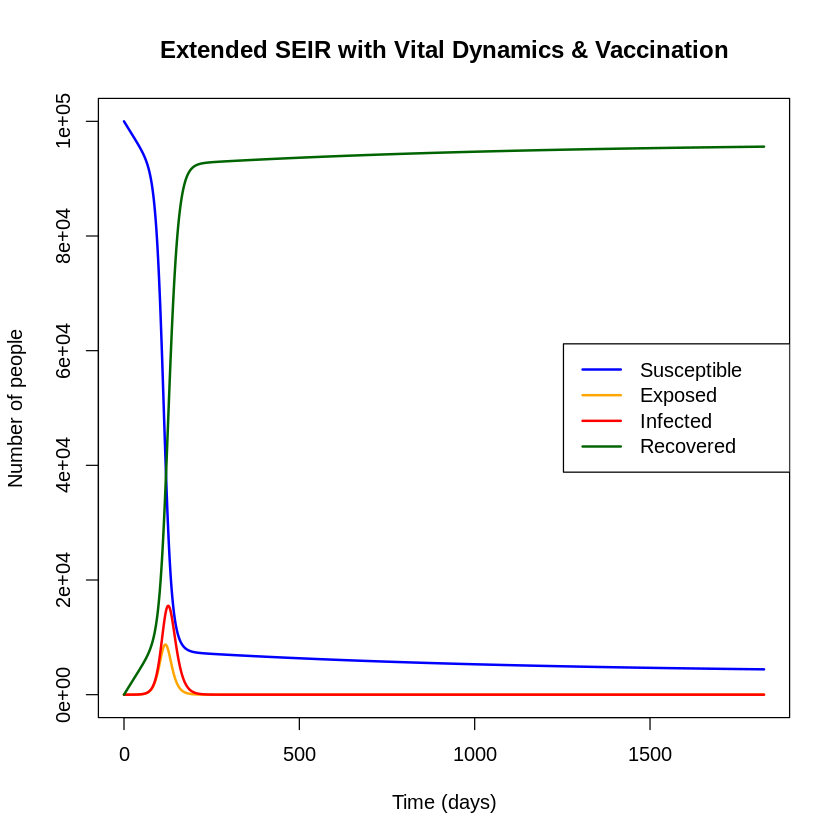

In [6]:
library(deSolve)

# Parameters
beta <- 0.3      # infection rate
gamma <- 0.1     # recovery rate
sigma <- 0.2     # incubation rate
mu <- 1/(70*365) # natural mortality/birth rate (~1/70 years)
nu <- 0.001      # vaccination rate

# Initial conditions
init_ext <- c(S = S0, E = 0, I = I0, R = R0)

# Extended SEIR model
seir_ext <- function(time, state, parameters) {
  with(as.list(c(state, parameters)), {
    dS <- mu*N - beta*S*I/N - mu*S - nu*S
    dE <- beta*S*I/N - sigma*E - mu*E
    dI <- sigma*E - gamma*I - mu*I
    dR <- gamma*I + nu*S - mu*R
    return(list(c(dS, dE, dI, dR)))
  })
}

params_ext <- c(beta=beta, gamma=gamma, sigma=sigma, mu=mu, nu=nu)
times_long <- seq(0, 365*5, by=1)  # simulate 5 years

out_ext <- ode(y=init_ext, times=times_long, func=seir_ext, parms=params_ext)
out_ext <- as.data.frame(out_ext)

# Plot results
matplot(out_ext$time, out_ext[,2:5], type="l", lwd=2, lty=1,
        col=c("blue","orange","red","darkgreen"),
        xlab="Time (days)", ylab="Number of people",
        main="Extended SEIR with Vital Dynamics & Vaccination")
legend("right", legend=c("Susceptible","Exposed","Infected","Recovered"),
       col=c("blue","orange","red","darkgreen"), lty=1, lwd=2)

## Section 5 — Stochastic Epidemiology

Deterministic models (ODEs) give smooth epidemic curves,
but real outbreaks are random: especially in small populations.

We use **the Gillespie stochastic simulation algorithm (SSA)**:

- Each event (infection, recovery) happens at random time steps.
- Probabilities depend on current state (S, I, R).
- Running many simulations shows variability in outcomes (epidemic may even die out early).

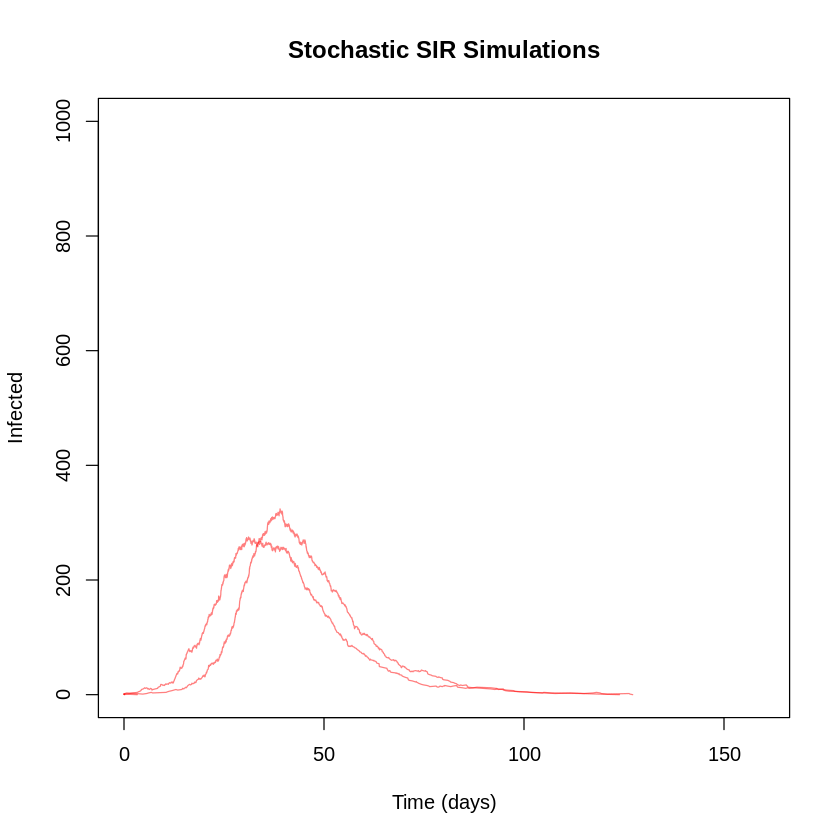

In [7]:
# Gillespie stochastic simulation for SIR

sir_gillespie <- function(S0, I0, R0, beta, gamma, N, t_max) {
  S <- S0; I <- I0; R <- R0
  time <- 0
  result <- data.frame(time=0, S=S, I=I, R=R)

  while(time < t_max & I > 0) {
    # Rates of events
    rate_infection <- beta * S * I / N
    rate_recovery  <- gamma * I
    total_rate <- rate_infection + rate_recovery

    if(total_rate <= 0) break

    # Time to next event
    dt <- rexp(1, rate=total_rate)
    time <- time + dt

    # Choose which event happens
    if(runif(1) < rate_infection / total_rate) {
      # infection
      S <- S - 1
      I <- I + 1
    } else {
      # recovery
      I <- I - 1
      R <- R + 1
    }

    result <- rbind(result, data.frame(time=time, S=S, I=I, R=R))
  }

  return(result)
}

set.seed(123)
# Run one simulation
traj1 <- sir_gillespie(S0=999, I0=1, R0=0, beta=0.3, gamma=0.1, N=1000, t_max=160)

# Run multiple simulations
traj_list <- lapply(1:5, function(i) sir_gillespie(999,1,0,0.3,0.1,1000,160))

# Plot
plot(NA, xlim=c(0,160), ylim=c(0,1000), xlab="Time (days)", ylab="Infected",
     main="Stochastic SIR Simulations")
for(traj in traj_list) {
  lines(traj$time, traj$I, col=rgb(1,0,0,0.5))
}

## Section 6 — Parameter Estimation

Epidemiological models must be **fitted to data** (e.g., case counts).  
We typically estimate:

- Infection rate (β)  
- Recovery rate (γ)  
- Incubation rate (σ in SEIR)  

Approach:
1. Define model (e.g., SIR).  
2. Simulate the model with guessed parameters.  
3. Compare model output to observed data (least-squares or maximum likelihood).  
4. Optimize parameters to minimize error.

     beta     gamma 
0.3007081 0.1004203 


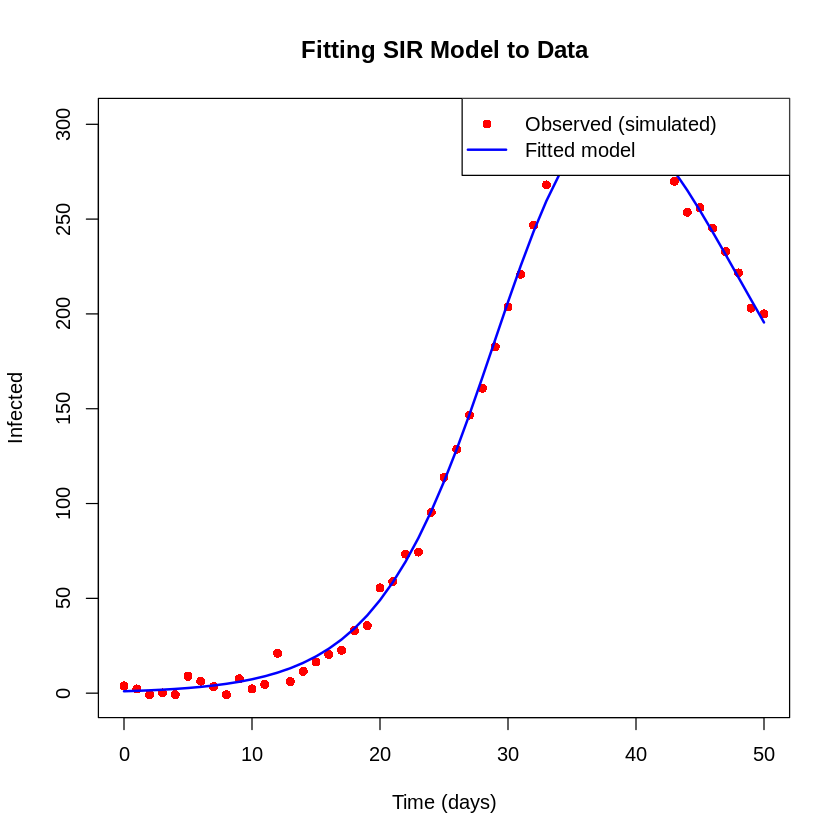

In [8]:
library(deSolve)

# --- True parameters (used to generate synthetic data) ---
beta_true <- 0.3
gamma_true <- 0.1
N <- 1000
init <- c(S = N-1, I = 1, R = 0)
times <- seq(0, 50, by=1)

sir_model <- function(time, state, parameters) {
  with(as.list(c(state, parameters)), {
    dS <- -beta * S * I / N
    dI <- beta * S * I / N - gamma * I
    dR <- gamma * I
    return(list(c(dS, dI, dR)))
  })
}

# Generate synthetic data for fitting
params_true <- c(beta=beta_true, gamma=gamma_true)
out_true <- ode(y=init, times=times, func=sir_model, parms=params_true)
I_obs <- out_true[, "I"] + rnorm(length(times), 0, 5) # add noise

# --- Fitting function ---
rss <- function(params) {
  names(params) <- c("beta","gamma")
  out <- ode(y=init, times=times, func=sir_model, parms=params)
  I_model <- out[, "I"]
  sum((I_obs - I_model)^2)   # residual sum of squares
}

# Initial guesses
guess <- c(beta=0.2, gamma=0.05)

fit <- optim(guess, rss)
fit_par <- fit$par
print(fit_par)

# Compare fitted curve to observed
out_fit <- ode(y=init, times=times, func=sir_model, parms=fit_par)

plot(times, I_obs, pch=16, col="red",
     xlab="Time (days)", ylab="Infected",
     main="Fitting SIR Model to Data")
lines(out_fit[,"time"], out_fit[,"I"], col="blue", lwd=2)
legend("topright", c("Observed (simulated)","Fitted model"),
       col=c("red","blue"), pch=c(16,NA), lty=c(NA,1), lwd=2)

## Section 7 — Epidemic Control Scenarios

Epidemiological models are powerful for testing **intervention strategies**:

- **Vaccination** reduces susceptibles (S).  
- **Social distancing / masks** reduce infection rate (β).  
- **Treatment** increases recovery rate (γ).  

We can simulate different scenarios and compare epidemic curves.

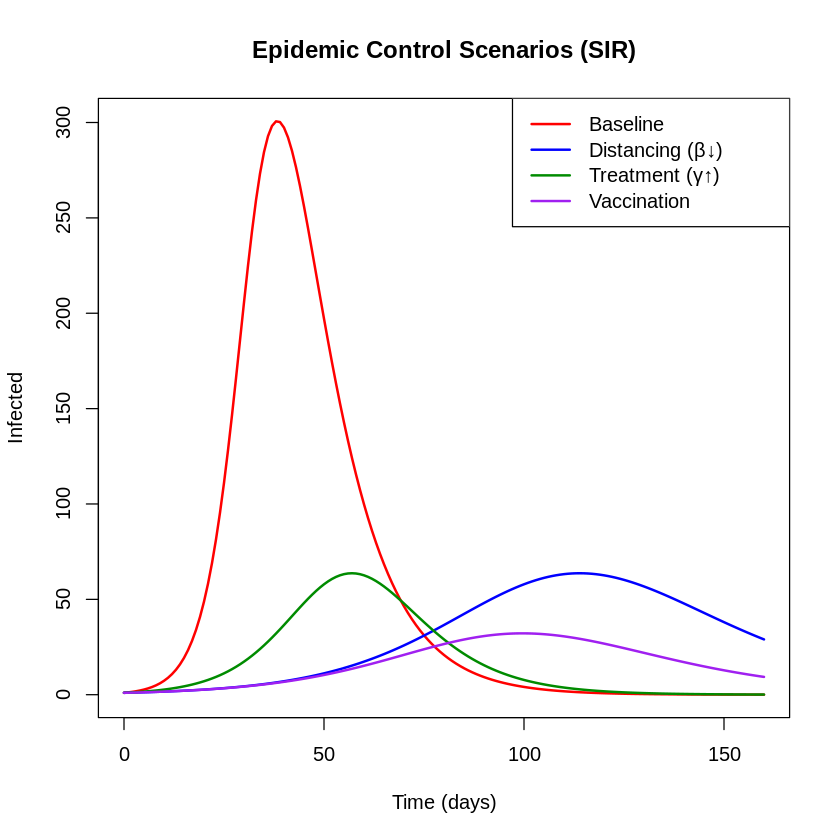

In [9]:
library(deSolve)

# --- Base parameters ---
N <- 1000
init <- c(S = N-1, I = 1, R = 0)
times <- seq(0, 160, by=1)

sir_model <- function(time, state, parameters) {
  with(as.list(c(state, parameters)), {
    dS <- -beta * S * I / N
    dI <- beta * S * I / N - gamma * I
    dR <- gamma * I
    return(list(c(dS, dI, dR)))
  })
}

# Scenario 1: Baseline (no intervention)
params_base <- c(beta=0.3, gamma=0.1)
out_base <- as.data.frame(ode(y=init, times=times, func=sir_model, parms=params_base))

# Scenario 2: Social distancing (reduce beta)
params_dist <- c(beta=0.15, gamma=0.1)
out_dist <- as.data.frame(ode(y=init, times=times, func=sir_model, parms=params_dist))

# Scenario 3: Faster recovery (treatment)
params_treat <- c(beta=0.3, gamma=0.2)
out_treat <- as.data.frame(ode(y=init, times=times, func=sir_model, parms=params_treat))

# Scenario 4: Vaccination at time 0 (50% vaccinated → move S → R)
init_vacc <- c(S = N*0.5-1, I = 1, R = N*0.5)
params_vacc <- c(beta=0.3, gamma=0.1)
out_vacc <- as.data.frame(ode(y=init_vacc, times=times, func=sir_model, parms=params_vacc))

# --- Plot infected curves ---
plot(times, out_base$I, type="l", col="red", lwd=2,
     xlab="Time (days)", ylab="Infected",
     main="Epidemic Control Scenarios (SIR)")
lines(times, out_dist$I, col="blue", lwd=2)
lines(times, out_treat$I, col="green4", lwd=2)
lines(times, out_vacc$I, col="purple", lwd=2)

legend("topright", legend=c("Baseline","Distancing (β↓)","Treatment (γ↑)","Vaccination"),
       col=c("red","blue","green4","purple"), lwd=2)

## Section 8 — Discussion & Policy Interpretation

We explored the main mathematical epidemiology tools:

1. **SIR Model**
   - Core epidemic dynamics with susceptible, infected, and recovered compartments.
   - Introduced R₀ (basic reproduction number).

2. **SEIR Model**
   - Added incubation (Exposed) compartment.
   - Showed delayed infection dynamics.

3. **Extensions**
   - Included births, deaths, and vaccination.
   - Demonstrated long-term equilibrium between infection and demography.

4. **Stochastic Models**
   - Highlighted randomness in outbreak outcomes.
   - Captures early extinction probabilities in small populations.

5. **Parameter Estimation**
   - Fitting models to noisy epidemic data.
   - Provided a method to recover β and γ from observations.

6. **Control Scenarios**
   - Social distancing (reduce β): flattens the curve.
   - Treatment (increase γ): shortens epidemic.
   - Vaccination: lowers susceptibles, preventing large outbreaks.

---

### Policy Takeaways

- **R₀ > 1** → epidemic grows; **R₀ < 1** → epidemic dies out.  
- **Vaccination threshold**: herd immunity is achieved when enough people are immune such that effective R₀ < 1.  
- **Interventions** affect parameters:
  - β lowered by distancing/masks.  
  - γ increased by better treatment.  
- **Stochasticity**: small outbreaks may extinguish naturally even if R₀ > 1, but relying on that is risky.  

---

### Linking to Health Economics

Mathematical epidemiology informs:
- **How many people are expected to get sick?**
- **What is the time course of an epidemic?**
- **What is the impact of vaccination programs or treatments?**

These forecasts can be integrated into **economic evaluations** (e.g., QALY gains, budget impact).

---

### Closing Note

This notebook demonstrates a foundational portfolio in **Epidemiological Modeling with R**.  
It prepares the ground for:
- Advanced compartmental models (age-structured, spatial).  
- Data-driven inference (Bayesian methods, MCMC).  
- Integration with health economics for policy decision-making.

## Section 9 — Bayesian Inference

Bayesian methods estimate parameters as **distributions**, not just single values.  
This allows direct uncertainty quantification: we can get posterior distributions for β, γ, and derived values like R₀.

Workflow:
1. Define the likelihood: data likelihood given model and parameters.
2. Assign priors to parameters.
3. Use MCMC sampling (e.g. with `rstan` or `rjags`) to approximate posterior.

In [ ]:

install.packages("rstan", repos = "https://cloud.r-project.org/")
library(rstan)

# Synthetic observed data (infected counts)
set.seed(123)
beta_true <- 0.3; gamma_true <- 0.1; N <- 500
init <- c(S = N-1, I = 1, R = 0)
times <- seq(0, 30, by=1)

sir_model <- function(time, state, parameters) {
  with(as.list(c(state, parameters)), {
    dS <- -beta * S * I / N
    dI <- beta * S * I / N - gamma * I
    dR <- gamma * I
    list(c(dS, dI, dR))
  })
}

out_true <- ode(y=init, times=times, func=sir_model, parms=c(beta=beta_true, gamma=gamma_true))
I_obs <- round(out_true[,"I"] + rnorm(length(times), 0, 3))  # noisy data
I_obs[I_obs < 0] <- 0

# ---- Stan model code ----
stan_code <- "
functions {
  real[] sir(real t, real[] y, real[] theta, real[] x_r, int[] x_i) {
    real S = y[1];
    real I = y[2];
    real R = y[3];
    real N = x_r[1];
    real beta = theta[1];
    real gamma = theta[2];

    real dS_dt = -beta * S * I / N;
    real dI_dt = beta * S * I / N - gamma * I;
    real dR_dt = gamma * I;

    return {dS_dt, dI_dt, dR_dt};
  }
}
data {
  int<lower=1> n_obs;
  real t0;
  real ts[n_obs];
  real y_init[3];
  real<lower=0> N;
  int I_obs[n_obs];
}
parameters {
  real<lower=0> beta;
  real<lower=0> gamma;
  real<lower=0> phi;   // noise scale
}
model {
  real y_hat[n_obs,3];
  real theta[2];

  theta[1] = beta;
  theta[2] = gamma;

  y_hat = integrate_ode_rk45(sir, y_init, t0, ts, theta, {N}, rep_array(0,0));

  // Priors
  beta ~ normal(0.3, 0.2);
  gamma ~ normal(0.1, 0.05);
  phi ~ exponential(1);

  // Likelihood
  for(i in 1:n_obs) {
    I_obs[i] ~ normal(y_hat[i,2], phi);
  }
}
"

# Prepare data list for Stan
stan_data <- list(
  n_obs = length(times),
  t0 = 0,
  ts = times,
  y_init = c(S=N-1, I=1, R=0),
  N = N,
  I_obs = as.integer(I_obs)
)

# Run Stan
fit <- stan(model_code=stan_code, data=stan_data, iter=1000, chains=2, refresh=0)

print(fit, pars=c("beta","gamma"))

# Posterior plots
posterior_samples <- extract(fit)
hist(posterior_samples$beta, col="skyblue", main="Posterior of beta", xlab="beta")
hist(posterior_samples$gamma, col="lightgreen", main="Posterior of gamma", xlab="gamma")

# Derived R0
R0_post <- posterior_samples$beta / posterior_samples$gamma
hist(R0_post, col="pink", main="Posterior of R0", xlab="R0")
abline(v=beta_true/gamma_true, col="red", lwd=2)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘abind’, ‘tensorA’, ‘distributional’, ‘checkmate’, ‘matrixStats’, ‘posterior’, ‘StanHeaders’, ‘inline’, ‘gridExtra’, ‘RcppParallel’, ‘loo’, ‘QuickJSR’, ‘RcppEigen’, ‘BH’


